<a href="https://colab.research.google.com/github/Steve-YJ/Colab_Exercise/blob/master/%5BRevision_JICS%5D%5BResNet_VAE%5DModeling_%26_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README
> Revision!<br>
Revise the Paper & Add more Experiments


*  10월에 투고했던 JICS로부터 논문 수정 요청을 받았다
*  다양한 모델을 통해 변종 악성코드 분류를 위한 실험을 수행해보자
    * 벤치마크 논문의 결과와 비교할 수 있도록 다양한 실험 수행
    * Logistic Regression, SVM 등 기본적인 선형모델부터 Ensemble, Stacking 등 다양한 Ensemble 모델을 활용한 모델까지 실험을 많이 해보도록 한다

## Log
* ✅ 데이터 로드 및 Baseline
    * baseline에서 시작해 모델을 발전시키는 방법에 대해서도 학습하고 적용해보도록 하자


# Mount Drive
* Experiment setup
    * 실험 환경 구축
    * Google Drive Mount
    * data path, latent vector 저장 경로 등 지정

In [1]:
# Mount Drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%load_ext autoreload
%autoreload 2
%cd drive/My\ Drive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master
! ls

/content/drive/My Drive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master
'01.Tutorial-ResNet-VAE.ipynb의 사본'
 01.Tutorial-ResNet-VAE-Recon.ipynb
 02.Tutorial-ResNet-VAE-Tunning.ipynb
 03.Tutorial-ResNet-VAE-Tunning.ipynb
'03.Tutorial-ResNet-VAE-Tunning.ipynb의 사본'
'04.Post-01.Tutorial-ResNet-VAE.ipynb사본의 사본'
'05.Post-01.Tutorial-ResNet-VAE_Train_Again.ipynb의 사본'
' 123'
 19train_val_plot.png
 201125_fine-tuned-SVM_PCA_before_CV.csv
'(원본.21.02.16.tue)_[Again][ResNet-VAE] [JICS] Exp02.  Model Evaluation.ipynb'
 39train_val_plot.png
 59train_val_plot.png
 Again_ResNet-VAE_Exp01
'[Again][ResNet-VAE] Exp2_3_1. Transfer Learning Using ResNet-VAE'\''Encoer.ipynb'
'[Again][ResNet-VAE] Exp2_3_1. Transfer Learning Using ResNet-VAE'\''Encoer.ipynb의 사본'
'[Again][ResNet-VAE] [JICS] Exp01. Feature_Extraction_using pre-trained ResNet-VAE Encoder _and_Classification_Ensemble .ipynb의 사본의 사본'
'[Again][ResNet-VAE] [JICS] Exp01. Feature_Ex

In [3]:
import os

def check_mkdir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        print("dir_make!!")
    else:
        print("already made it!")

In [4]:
check_mkdir('./ResNet-VAE_Exp2_3_1.ResNet-VAE_Encoder_Transfer_Learning')

already made it!


# 01. Import Library

pre-trained ResNet-VAE 모델을 정의하고 불러오기 위해 관련 라이브러리 import

In [41]:
from PIL import Image
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

# save single numpy array
from tempfile import TemporaryFile
from sklearn.manifold import TSNE

import torch
import torch.utils.data  # torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

# argparse
import argparse
import time

import torchvision 
from torchvision import datasets, transforms
from torchvision.utils import save_image

# load modules
from torchvision import models
from modules import *

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")



from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

<code>save_path</code>: 실험 결과를 저장하는 변수 생성

In [6]:
save_path =  'ResNet-VAE_Exp2_3_1.ResNet-VAE_Encoder_Transfer_Learning'
save_model_path = save_path
epoch = 90

print(save_model_path)
print("Epoch: ", 90)

ResNet-VAE_Exp2_3_1.ResNet-VAE_Encoder_Transfer_Learning
Epoch:  90


save_model_path는 save_path와 같게 한다<br>
Epoch의 경우 90번째 Epoch의 학습 파라미터를 불러올 것이기에 90으로 설정해준다

# 02. Prepare Data
* save_model_path에 저장되었던 latent vector값을 불러온다
* <code>latent_vector</code>는 ResNet-VAE의 Encoder Network로부터 추출한 변종 악성코드의 특징정보 데이터가 된다

In [7]:
latent_vector = np.load('./'+save_model_path+'/{}Epoch_z_vector_eval_2.npy'.format(epoch))
print("Load Latent_Vector!!")
print(latent_vector.shape)

Load Latent_Vector!!
(9339, 257)


pandas dataframe으로 데이터를 변환시켜준다
* 데이터를 관측하기에 용이하며
* 모델링에도 도움이 된다?!

In [8]:
# numpy to pandas
import pandas as pd

df = pd.DataFrame(data=latent_vector)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256
0,-0.079755,-0.147424,-0.189230,0.194458,0.388388,-0.119072,0.109736,-0.056990,-0.800721,0.050581,0.532725,-0.610358,-0.017369,-0.374537,0.208201,-0.799917,-0.427418,-0.318003,-0.198780,-0.363913,0.365756,0.138464,-0.104773,-0.344742,-0.286471,0.257573,0.256363,-0.063435,-0.167919,-0.064486,0.343131,0.126364,0.306907,-0.033746,-0.586487,1.494787,0.050350,-0.292049,0.171634,0.360474,...,-0.507517,0.057923,-0.772096,-0.064201,0.275395,0.477230,0.509851,-0.102962,-0.138262,-0.235437,-0.074715,-0.026238,-0.046062,-0.373379,0.006486,-0.281289,0.081987,-0.494027,-0.317230,0.354119,0.031277,-0.109128,0.068695,0.112275,0.246333,-0.211417,0.058181,-0.148344,-0.095267,0.065737,-0.132259,-0.690135,-0.131619,-0.005944,-0.508376,0.114063,0.047721,0.031916,-0.250866,0.0
1,-0.075697,-0.141241,-0.202255,0.196442,0.368280,-0.108913,0.099139,-0.046670,-0.808449,0.057153,0.566733,-0.600700,-0.027950,-0.365823,0.195029,-0.808766,-0.409371,-0.324253,-0.232683,-0.373019,0.370960,0.130696,-0.108057,-0.333581,-0.305560,0.259043,0.227698,-0.055702,-0.177057,-0.072627,0.388489,0.141433,0.334636,-0.029527,-0.607663,1.497099,0.072859,-0.286685,0.197342,0.339403,...,-0.500877,0.042102,-0.776329,-0.034242,0.280909,0.480071,0.531972,-0.126357,-0.140308,-0.253910,-0.033572,-0.028036,-0.052304,-0.364376,-0.007183,-0.286341,0.088019,-0.501302,-0.266955,0.337196,0.037516,-0.117771,0.061113,0.111606,0.229591,-0.199158,0.062549,-0.161465,-0.093055,0.059573,-0.140040,-0.741642,-0.143201,-0.032876,-0.539519,0.110870,0.042003,-0.002187,-0.264128,0.0
2,-0.186946,-0.214237,-0.035928,0.453943,0.340568,0.030594,0.291855,-0.119232,-0.593898,0.103341,0.375293,-0.652887,0.254407,-0.426121,0.210909,-0.720233,-0.449404,-0.187847,-0.120922,-0.523257,0.299585,0.173396,0.008157,-0.107134,-0.157367,0.176205,0.302289,-0.023242,-0.074439,0.069249,0.081371,0.067526,0.204558,0.163602,-0.514052,1.542358,0.129169,-0.311420,0.029873,0.121453,...,-0.483379,0.115042,-0.864364,-0.055711,0.385580,0.409733,0.360030,-0.156150,-0.425852,-0.159641,-0.231702,0.111767,-0.102522,-0.358673,0.023472,0.041521,0.043106,-0.481426,-1.051561,0.146567,-0.095436,0.049812,0.129441,-0.058521,0.309234,-0.162010,0.054403,-0.189988,-0.041328,0.271529,-0.227674,-0.943851,0.014254,0.171478,-0.293101,0.091535,0.095283,0.175777,-0.116401,0.0
3,-0.183893,-0.218137,-0.033342,0.455784,0.339456,0.032361,0.291033,-0.123609,-0.589514,0.106223,0.367628,-0.653506,0.258564,-0.428709,0.213754,-0.723281,-0.445179,-0.191620,-0.119291,-0.525154,0.299489,0.172470,0.003429,-0.107723,-0.158817,0.173379,0.306515,-0.025969,-0.080091,0.077793,0.076868,0.061462,0.189486,0.166671,-0.507873,1.539625,0.128002,-0.312537,0.029707,0.122561,...,-0.482540,0.121622,-0.860716,-0.056947,0.383539,0.407519,0.356227,-0.148399,-0.427754,-0.154318,-0.239867,0.116229,-0.102825,-0.354691,0.022044,0.043723,0.043092,-0.474519,-1.063762,0.145921,-0.101801,0.047349,0.128657,-0.059488,0.309853,-0.161441,0.047066,-0.189032,-0.034334,0.266426,-0.230699,-0.931323,0.010270,0.168781,-0.286626,0.093486,0.100982,0.186238,-0.115219,0.0
4,-0.175223,-0.216755,-0.033997,0.452481,0.324202,0.036710,0.271277,-0.120302,-0.590318,0.109478,0.365225,-0.639969,0.261805,-0.426624,0.216680,-0.721274,-0.413379,-0.188058,-0.137833,-0.527597,0.293229,0.153509,-0.002452,-0.104806,-0.172644,0.172201,0.296448,-0.023418,-0.099792,0.095341,0.103122,0.057123,0.182507,0.163882,-0.517347,1.522830,0.147741,-0.308423,0.043511,0.104968,...,-0.456805,0.129677,-0.905839,-0.046321,0.370809,0.416456,0.367649,-0.152300,-0.429156,-0.160807,-0.228626,0.137353,-0.099813,-0.334947,0.011738,0.044286,0.042627,-0.458977,-1.041680,0.138533,-0.118311,0.036777,0.128950,-0.066132,0.296580,-0.144383,0.035032,-0.188733,-0.005631,0.266176,

In [9]:
df.iloc[:, -1].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.])

악성코드의 클래스는 25개이다

In [10]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256
count,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,...,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000,9339.000000
mean,-0.014672,-0.121506,0.006760,-0.039965,0.024616,0.054779,-0.002225,0.137880,-0.133754,-0.045067,-0.078351,-0.000560,0.064432,0.051751,0.030630,-0.029263,-0.065104,0.138334,0.013031,0.168067,0.015283,0.060863,0.070276,-0.046600,-0.019792,0.007160,-0.024737,0.024124,0.020241,-0.024392,0.025986,0.019529,-0.018198,0.041047,0.145876,0.355250,-0.104725,-0.008840,-0.047456,-0.032281,...,-0.009641,0.175106,-0.284139,-0.069312,-0.049342,0.066115,0.003565,-0.051441,0.072375,0.015366,0.014893,-0.053322,-0.047126,-0.069323,0.046552,-0.206073,0.072312,0.033137,0.179544,-0.054524,-0.065951,0.012691,0.033019,-0.125531,0.117211,-0.000245,0.156953,0.023645,0.025238,-0.022369,0.050767,-0.146758,0.032293,0.076376,-0.098583,-0.002373,0.038568,-0.110075,0.065328,8.518899
std,0.310038,0.335135,0.189444,0.288269,0.207774,0.348571,0.222052,0.252297,0.297715,0.212980,0.318498,0.265886,0.223754,0.321827,0.161984,0.386011,0.381880,0.262605,0.316454,0.402784,0.170926,0.283506,0.229496,0.271693,0.172227,0.247881,0.321206,0.188737,0.224634,0.177321,0.322896,0.239064,0.418588,0.311142,0.404699,0.852568,0.308673,0.219576,0.257742,0.274686,...,0.190405,0.294997,1.510563,0.225420,0.203351,0.212916,0.183992,0.260770,0.285114,0.340797,0.351298,0.274745,0.204111,0.271937,0.219158,0.531889,0.414359,0.162549,0.799583,0.277597,0.210696,0.188764,0.236777,0.274059,0.317343,0.358730,0.250376,0.298005,0.203242,0.262828,0.339208,0.835157,0.194960,0.288074,0.304688,0.256131,0.284184,0.392996,0.290852,7.885406
min,-2.103440,-1.750987,-1.109677,-0.890437,-1.290085,-2.256345,-1.683124,-1.836054,-1.543239,-0.947767,-1.236308,-1.465475,-1.361249,-1.588804,-0.690776,-1.527677,-1.834702,-1.559180,-2.237509,-2.263640,-1.785201,-1.332574,-1.250548,-1.436959,-0.797588,-2.666174,-1.638455,-1.109393,-1.328993,-0.788072,-2.416469,-1.766153,-2.038032,-1.646123,-3.301250,-2.585868,-1.385717,-0.928726,-1.230018,-2.070546,...,-0.832142,-2.402503,-5.163221,-2.331334,-1.115332,-2.841242,-1.021519,-1.060687,-1.952762,-2.776561,-1.849074,-1.445123,-0.981382,-1.739263,-0.840979,-2.700004,-2.587259,-0.891617,-7.583395,-1.880782,-1.406572,-0.773877,-2.122551,-0.889392,-2.225008,-1.194950,-1.741693,-2.597230,-0.975779,-1.566789,-2.739656,-4.422934,-1.038577,-1.639474,-1.645329,-1.515253,-1.908276,-2.195489,-2.525687,0.000000
25%,-0.165177,-0.354445,-0.062005,-0.249967,-0.049712,-0.134528,-0.072806,0.011222,-0.318528,-0.189820,-0.300221,-0.165850,-0.015727,-0.137511,-0.072603,-0.192460,-0.255822,0.044824,-0.106733,-0.112054,-0.041952,-0.052855,-0.027045,-0.189945,-0.097707,-0.081913,-0.112959,-0.037401,-0.068117,-0.147228,-0.124424,-0.135460,-0.222509,-0.097427,-0.094046,-0.026039,-0.328014,-0.143986,-0.175606,-0.154875,...,-0.131886,0.048812,-1.787176,-0.187677,-0.151939

* 🤔 Q. Latent Vector를 정규화? 스케일링? 시켜주면 결과가 더 좋아질까?
    * -21.02.16.Tue-
    * 우선은 다음 작업으로 넘어가자(학습하는게 오늘의 목표...!) - 21.02.19.Fri-

# Modeling

In [11]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]

print(X.shape, y.shape)

(9339, 256) (9339,)


* Q. Which model should I use?
* Q. Would it be done just by making a model and making predictions?

In [17]:
from sklearn.multiclass import OneVsRestClassifier 
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, classification_report 
from sklearn.model_selection import train_test_split 
import warnings
import numpy as np
from sklearn.model_selection import train_test_split


X, y = df.iloc[:, :-1], df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

print("X_train/X_val/X_test.shapes &  y_train/y_val/y_test.shapes")
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)


'''
Reference: https://www.geeksforgeeks.org/one-vs-rest-strategy-for-multi-class-classification/
'''
# Creating the SVM model 
model = OneVsRestClassifier(SVC()) 
   
# Fitting the model with training data 
model.fit(X_train, y_train) 
   
# Making a prediction on the test set 
preds = model.predict(X_val) 
   
# Evaluating the model 
print(f"Val Set Accuracy : {accuracy_score(y_val, preds) * 100} %\n\n") 
print(f"Classification Report : \n\n{classification_report(y_val, preds)}")

# test prediction & save_results
# (save test result)
preds = model.predict(X_test)
df_clf = pd.DataFrame(classification_report(y_test, preds, output_dict=True)).transpose()
filename = input("Enter save file name: ")
df_clf.to_csv(filename)
print("results saved!")

X_train/X_val/X_test.shapes &  y_train/y_val/y_test.shapes
(5603, 256) (1868, 256) (1868, 256) (5603,) (1868,) (1868,)
Val Set Accuracy : 96.1456102783726 %


Classification Report : 

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        24
         1.0       1.00      1.00      1.00        25
         2.0       1.00      1.00      1.00       561
         3.0       1.00      1.00      1.00       340
         4.0       1.00      1.00      1.00        33
         5.0       0.00      0.00      0.00        32
         6.0       0.81      0.88      0.84        24
         7.0       0.89      0.85      0.87        39
         8.0       1.00      1.00      1.00        30
         9.0       1.00      1.00      1.00        40
        10.0       0.99      0.97      0.98        80
        11.0       1.00      1.00      1.00        97
        12.0       0.96      1.00      0.98        44
        13.0       1.00      0.95      0.97        37
    

In [18]:
df_test = pd.read_csv('SVC_test_preds_0302.csv')
df_test

,Unnamed: 0,precision,recall,f1-score,support
0,0.0,0.972973,1.000000,0.986301,36.000000
1,1.0,1.000000,1.000000,1.000000,19.000000
2,2.0,0.998311,0.998311,0.998311,592.000000
3,3.0,1.000000,0.993548,0.996764,310.000000
4,4.0,1.000000,1.000000,1.000000,45.000000
5,5.0,0.000000,0.000000,0.000000,18.000000
6,6.0,0.851852,0.920000,0.884615,25.000000
7,7.0,0.857143,0.833333,0.845070,36.000000
8,8.0,1.000000,1.000000,1.000000,49.000000
9,9.0,1.000000,1.000000,1.000000,34.000000


## Confusion Matrix

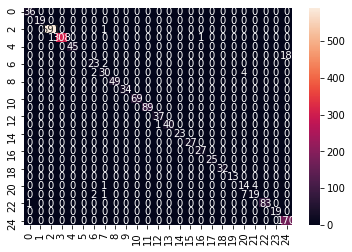

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

# confusion_matrix
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt="d")

## AUC-ROC Curve

In [38]:
n_classes = df.iloc[:, -1].unique()

n_class = []
for c in n_classes:
    # print(round(c))
    n_class.append(round(c))

print(n_class)

n_classes = len(n_class)
print(n_classes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
25


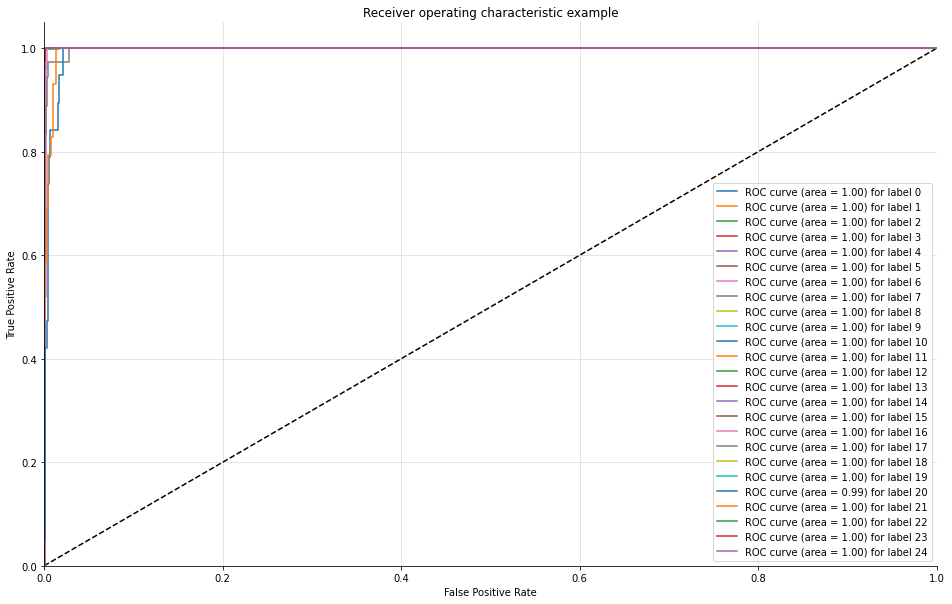

In [42]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(model, X_test, y_test, n_classes=25, figsize=(16, 10))


In [36]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

KeyError: ignored

## Advanced Model
> 어떤 과정들을 추가해주면 좋을까...?<br>
AutoEncoder의 Encoder로부터 추출한 Latent Vector이기에...! CNN 계열의 알고리즘으로 학습시켜주는것도 좋을 것 같다...!

* SVM 외에 다른 분류기로도 실험을 해보자
    * 최근에 학습한 XGBoost 등....!
* 또한 Parameter Optimization(파라미터 최적화) 등도 수행해보자

### 1. RandomForest pipeline (Baseline?)
* RandomForestClassifier
* Pipelines

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

my_pipeline = Pipeline([
    # ('preprocessor', SimpleImputer()),
    ('model', RandomForestClassifier(random_state=42))
])

# Evaluate


# Metric for Report
* ROC Curve
* Confusion Matrix
* etc...